In [1]:
from utils import *
from models import *


import os
os.chdir('../..')
print(os.getcwd())


/Users/joyqiu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


using device:  cpu
using device:  cpu
/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns


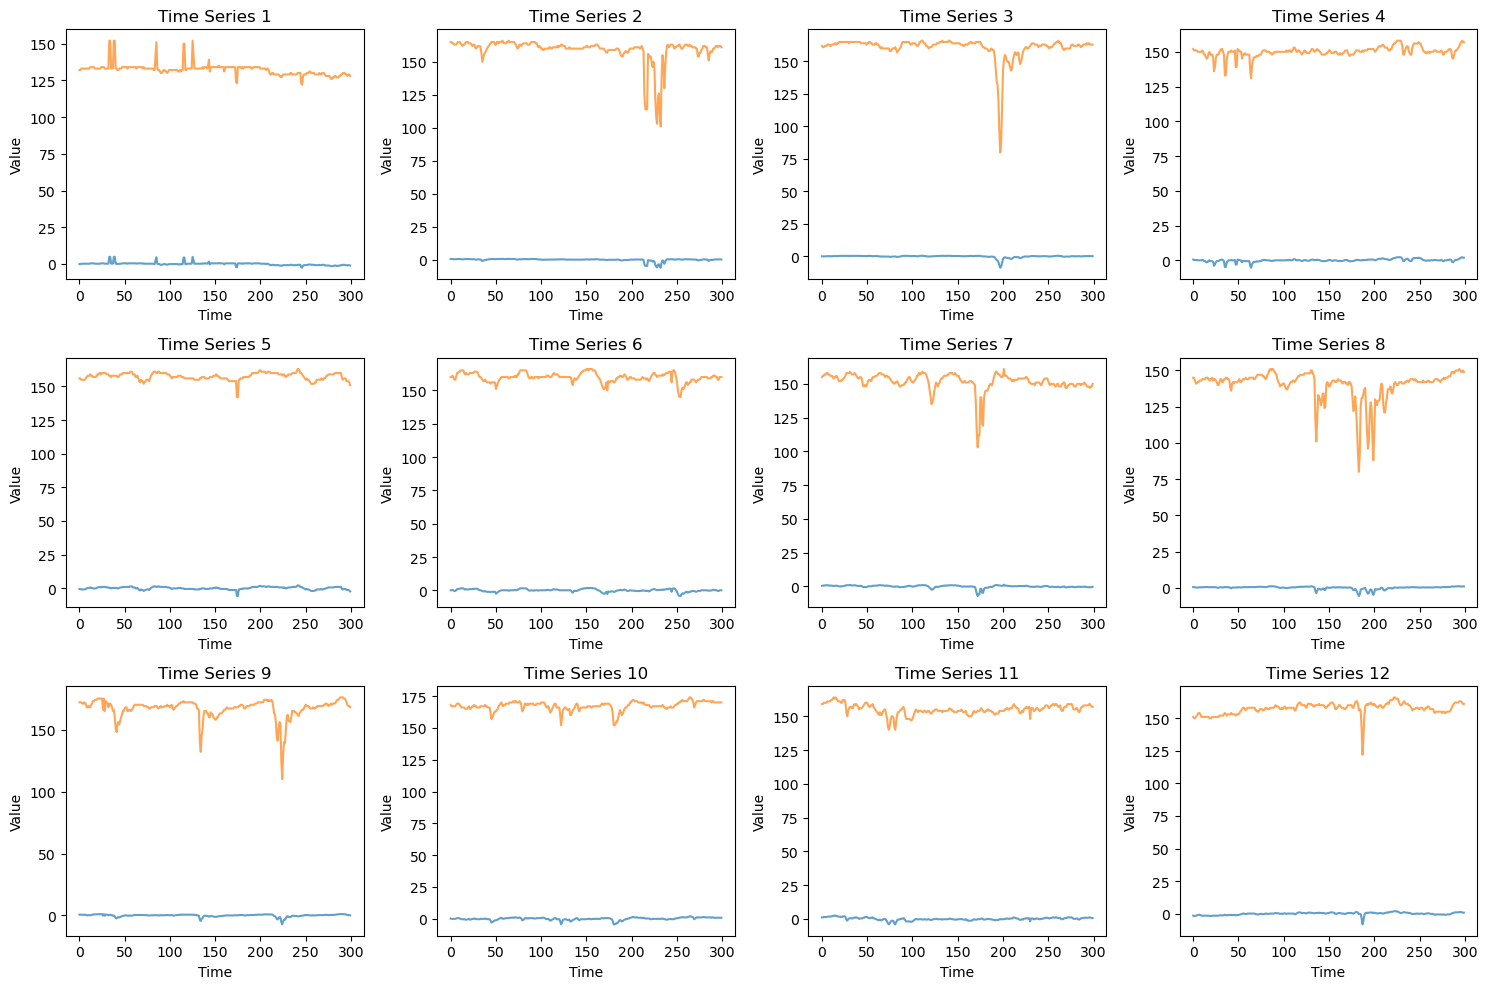

In [2]:
data_path = './data/PAS Challenge HR Data.xlsx'  
batch_size = 128
train_dataloader, test_dataloader, df_scaled, df = prepare_data(data_path, 
                                                                batch_size=batch_size, 
                                                                normalize=True)

In [3]:
overwrite = False
model_path = './script/VAE/results/hr_vae_beta_medium.pth' 
loss_path = './script/VAE/results/hr_train_test_losses_beta_medium.pth'
# Initialize model
model = BetaVAE_Medium(sequence_length=300,
                latent_dim=32,
                hidden_dim=128,
                beta=4.0,
                gamma=1000.0,
                c_max=25.0
                ).to(device)
nn_summary(model, 
        input_size=(batch_size, 300),
        col_names=["input_size", "output_size", "num_params", "kernel_size"],
        depth=4)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
BetaVAE_Medium                           [128, 300]                [128, 300]                --                        --
├─Sequential: 1-1                        [128, 300]                [128, 128]                --                        --
│    └─Linear: 2-1                       [128, 300]                [128, 128]                38,528                    --
│    └─LeakyReLU: 2-2                    [128, 128]                [128, 128]                --                        --
│    └─BatchNorm1d: 2-3                  [128, 128]                [128, 128]                256                       --
│    └─Linear: 2-4                       [128, 128]                [128, 256]                33,024                    --
│    └─LeakyReLU: 2-5                    [128, 256]                [128, 256]                --                        --
│    └─BatchNo

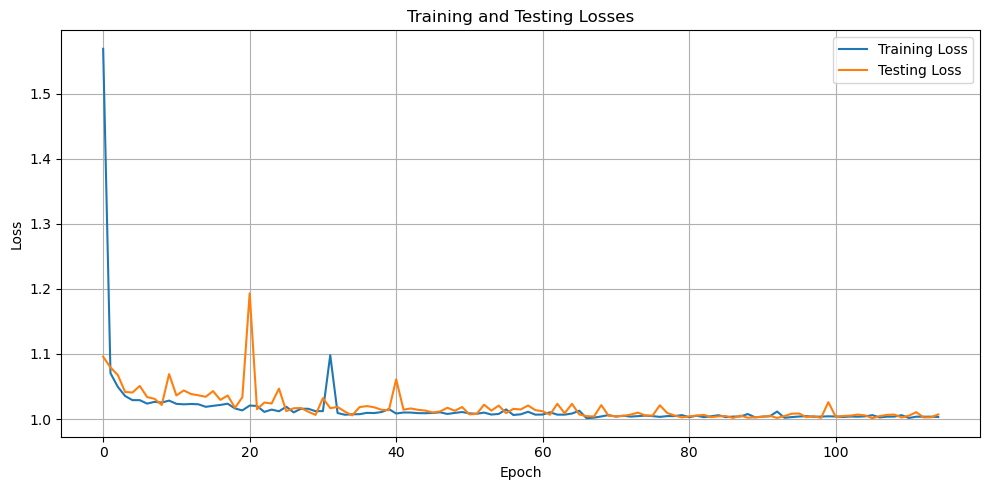

In [8]:

if not os.path.exists(model_path) or overwrite:
    # Train the model
    num_epochs = 10000000000000
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # Training
    for epoch in range(num_epochs):
        
        train_losses, test_losses = train(
            model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            num_epochs=num_epochs,
            device=device
        )
        # Save model locally
        torch.save(model.state_dict(), model_path)
        torch.save((train_losses, test_losses), loss_path)
else:
    # load model from model_path
    model.load_state_dict(torch.load(model_path))
    model.eval()
    train_losses, test_losses = torch.load(loss_path)
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(test_losses, label='Testing Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    # ax1.set_ylim(0, 1)
    ax1.set_title('Training and Testing Losses')
    ax1.legend()
    ax1.grid(True)


    plt.tight_layout()
    plt.show()



# wonderful!

Training Data Reconstructions:


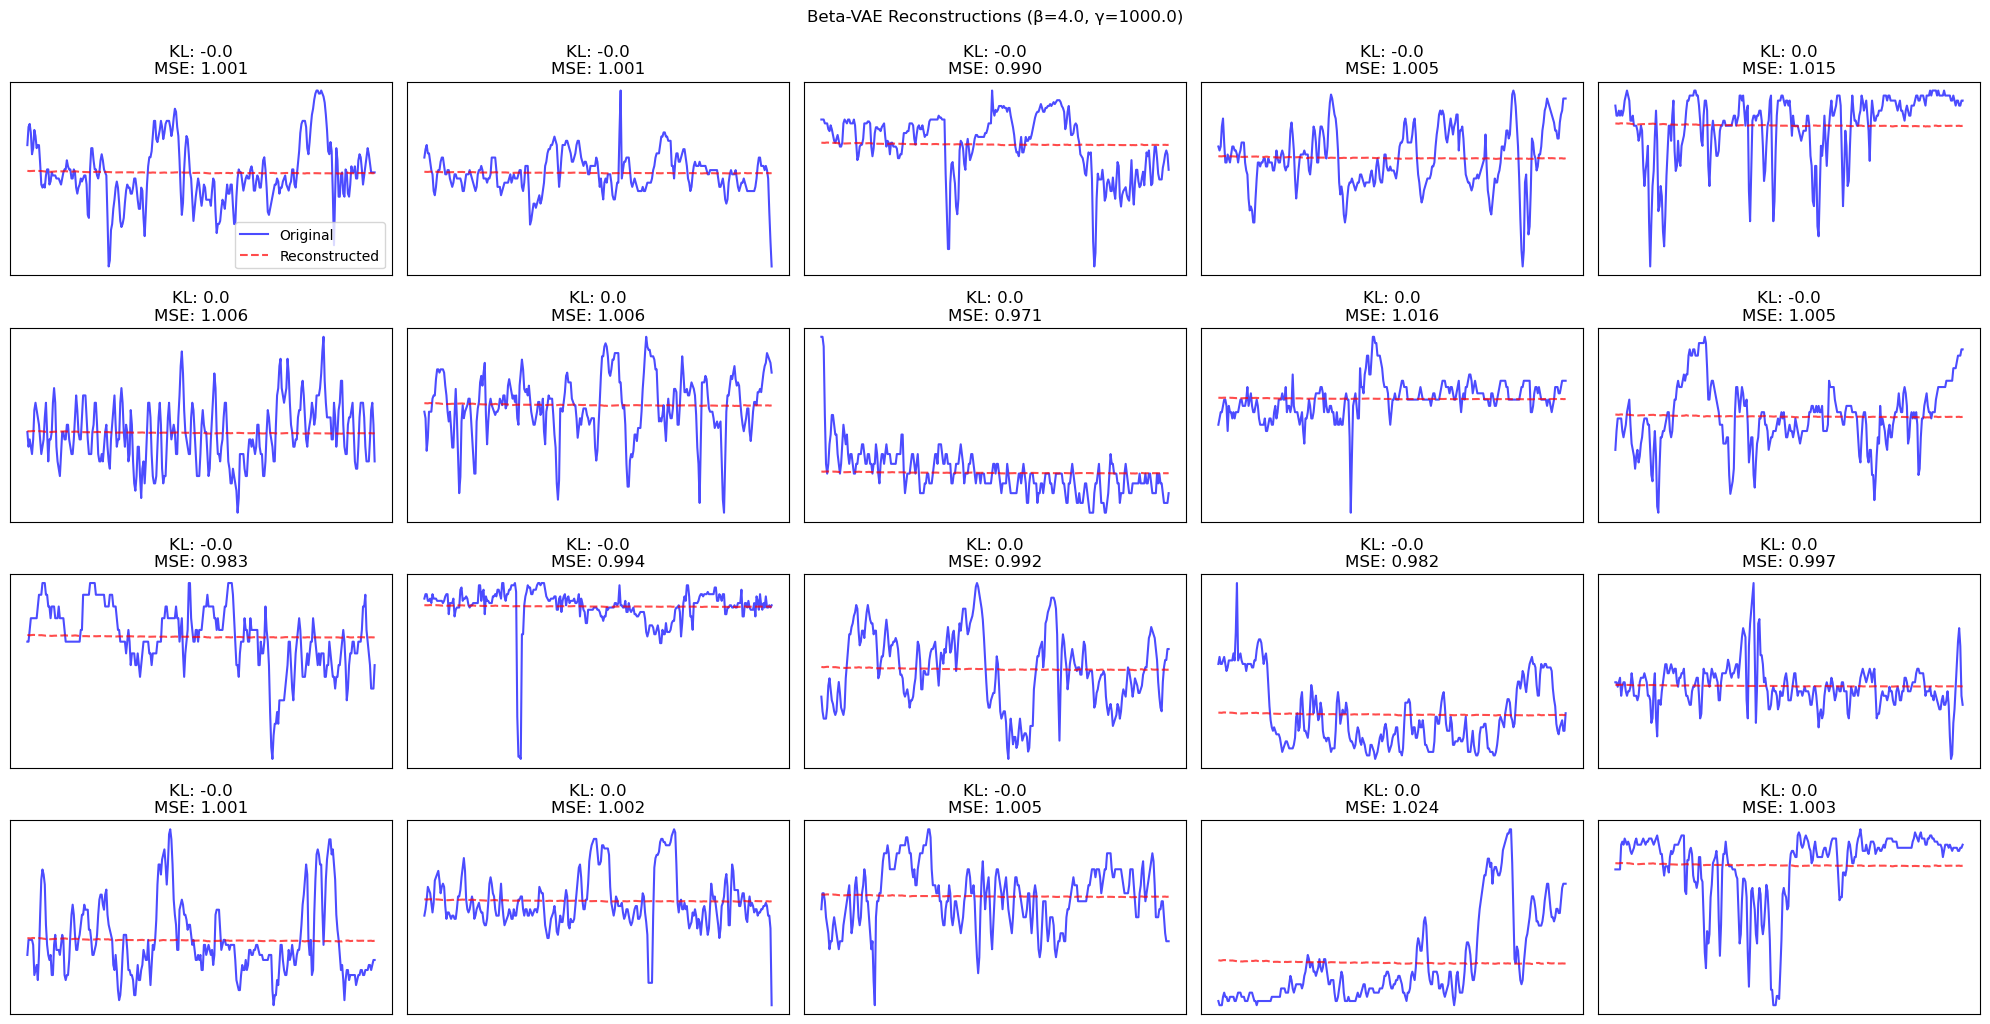


Test Data Reconstructions:


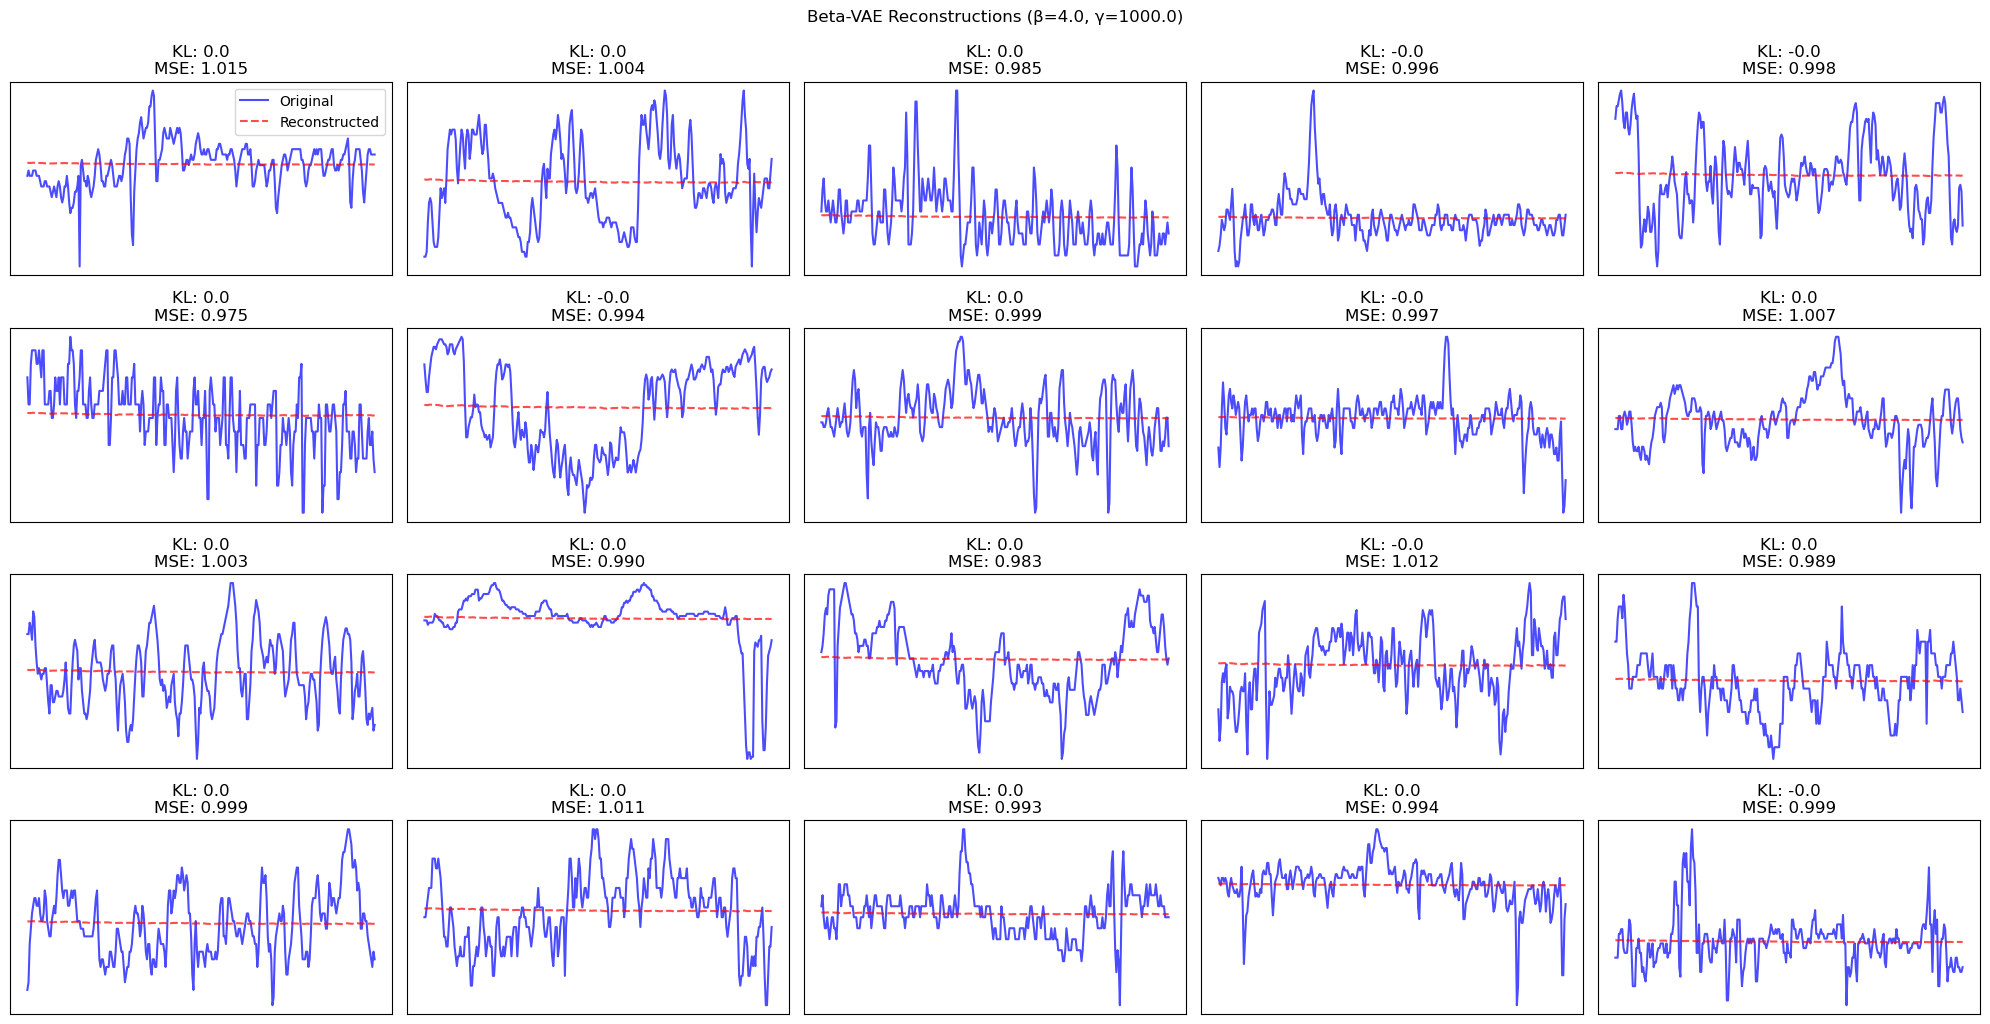

In [13]:
def plot_vae_reconstructions(model, dataloader, num_samples=20):
    """Plot original vs reconstructed samples from Beta-VAE"""
    model.eval()
    fig, axes = plt.subplots(4, 5, figsize=(20, 10), facecolor='white')
    
    with torch.no_grad():
        for i in range(num_samples):
            # Get a sample and add batch dimension
            x = dataloader.dataset[i].to(model.fc_mu.weight.device)
            x = x.unsqueeze(0)  # Add batch dimension [1, sequence_length]
            
            # Get reconstruction and latent parameters
            x_hat, mu, log_var = model(x)
            
            # Calculate KL divergence for this sample
            kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()).item()
            
            # Calculate reconstruction error
            recon_error = F.mse_loss(x_hat, x, reduction='mean').item()
            
            # Plot
            ax = axes[i//5, i%5]
            ax.plot(x.squeeze().cpu().numpy(), 'b-', label='Original', alpha=0.7)
            ax.plot(x_hat.squeeze().cpu().numpy(), 'r--', label='Reconstructed', alpha=0.7)
            
            # Add title with KL and reconstruction error
            ax.set_title(f'KL: {kl_div:.1f}\nMSE: {recon_error:.3f}')
            
            if i == 0:  # Only show legend for first plot
                ax.legend()
            
            # Remove axis labels to reduce clutter
            ax.set_xticks([])
            ax.set_yticks([])
    
    plt.tight_layout()
    fig.suptitle(f'Beta-VAE Reconstructions (β={model.beta}, γ={model.gamma})', y=1.02)
    plt.show()

# Plot training samples
print("Training Data Reconstructions:")
plot_vae_reconstructions(model, train_dataloader)

# Plot test samples
print("\nTest Data Reconstructions:")
plot_vae_reconstructions(model, test_dataloader)